## Install libs

In [1]:
import os
os.environ['HF_ENDPOINT'] = 'https://hf-mirror.com'
os.environ["HF_HUB_ENABLE_HF_TRANSFER"] = "1"
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [ ]:
# set global pip proxy
!mkdir -p ~/.pip && echo -e '[global]\nindex-url = https://pypi.tuna.tsinghua.edu.cn/simple\ntrusted-host = pypi.tuna.tsinghua.edu.cn' >> ~/.pip/pip.conf

In [ ]:
!pip install torch torchvision transformers datasets accelerate trl bitsandbytes peft qwen-vl-utils

In [ ]:
# Do not use this way to install flash attention since it is too slow in China
# !uv pip install flash-attn --no-build-isolation --system -i https://pypi.tuna.tsinghua.edu.cn/simple -v

# The file flash_attn-2.7.4.post1+cu12torch2.2cxx11abiFALSE-cp310-cp310-linux_x86_64.whl 
# from https://github.com/Dao-AILab/flash-attention/releases contains key info：
#       cu12：CUDA 12.x
#       torch2.2：PyTorch 2.2
#       cp310：Python 3.10 
#       FALSE: PyTorch C++ ABI status
#              you can check it by 
#              import torch; print(torch._C._GLIBCXX_USE_CXX11_ABI)
!pip install flash_attn-2.7.4.post1+cu12torch2.4cxx11abiFALSE-cp311-cp311-linux_x86_64.whl

## Load dataset

In [ ]:
from datasets import load_dataset, Dataset
from sklearn.model_selection import train_test_split

model_dataset_path = "/data" # hf mirror貌似不工作了，所以把模型和数据都下载到本地

# 加载原始数据
dataset_id = os.path.join(model_dataset_path, "deepfashion-multimodal")
dataset = load_dataset(dataset_id)
data = dataset["data"]

# 按比例划分为 train/valid/test = 80%/10%/10%
train_valid_test = data.train_test_split(test_size=0.2, seed=42)
valid_test = train_valid_test["test"].train_test_split(test_size=0.5, seed=42)
train = train_valid_test["train"]
valid = valid_test["train"]
test = valid_test["test"]

In [3]:
system_message = """You are a fashion product expert assistant who excels at identifying product types from images and generating concise descriptions."""
prompt = "What is this product?"

def format_data(sample):
    generation = f"{sample['category1']}/{sample['category2']}: {sample['text']}"
    return [
        {
            "role": "system",
            "content": [{"type": "text", "text": system_message}],
        },
        {
            "role": "user",
            "content": [
                {
                    "type": "image",
                    "image": sample["image"],
                },
                {
                    "type": "text",
                    "text": prompt,
                },
            ],
        },
        {
            "role": "assistant",
            "content": [{"type": "text", "text": generation}],
        },
    ]

In [4]:
train_dataset = [format_data(sample) for sample in train]
valid_dataset = [format_data(sample) for sample in valid]
test_dataset = [format_data(sample) for sample in test]

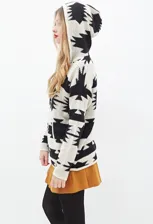

In [5]:
train_dataset[1][1]["content"][0]["image"]

## Load model

In [6]:
import torch
from transformers import Qwen2_5_VLForConditionalGeneration, AutoProcessor

model_id = os.path.join(model_dataset_path, "Qwen2.5-VL-3B-Instruct")
model = Qwen2_5_VLForConditionalGeneration.from_pretrained(
    model_id, 
    torch_dtype=torch.bfloat16,
    attn_implementation="flash_attention_2",
    device_map="auto"
)

processor = AutoProcessor.from_pretrained(model_id, padding_side='left')

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


## Config and start the training

In [7]:
from peft import LoraConfig, get_peft_model

# Configure LoRA
peft_config = LoraConfig(
    lora_alpha=16,
    lora_dropout=0.05,
    r=8,
    bias="none",
    target_modules=["q_proj", "v_proj"],
    task_type="CAUSAL_LM",
)

# Apply PEFT model adaptation
peft_model = get_peft_model(model, peft_config)

# Print trainable parameters
peft_model.print_trainable_parameters()

trainable params: 1,843,200 || all params: 3,756,466,176 || trainable%: 0.0491


In [8]:
from trl import SFTConfig

# Configure training arguments
training_args = SFTConfig(
    output_dir="/data/sdb/qwen2.5-3b-instruct-trl-sft-deepfashion",  # Directory to save the model
    num_train_epochs=1,  # Number of training epochs
    per_device_train_batch_size=8,  # Batch size for training
    per_device_eval_batch_size=8,  # Batch size for evaluation
    gradient_accumulation_steps=8,  # Steps to accumulate gradients
    gradient_checkpointing=True,  # Enable gradient checkpointing for memory efficiency
    # Optimizer and scheduler settings
    optim="adamw_torch_fused",  # Optimizer type
    learning_rate=2e-4,  # Learning rate for training
    lr_scheduler_type="constant",  # Type of learning rate scheduler
    # Logging and evaluation
    logging_steps=10,  # Steps interval for logging
    eval_steps=10,  # Steps interval for evaluation
    eval_strategy="steps",  # Strategy for evaluation
    save_strategy="steps",  # Strategy for saving the model
    save_steps=20,  # Steps interval for saving
    metric_for_best_model="eval_loss",  # Metric to evaluate the best model
    greater_is_better=False,  # Whether higher metric values are better
    load_best_model_at_end=True,  # Load the best model after training
    # Mixed precision and gradient settings
    bf16=True,  # Use bfloat16 precision
    tf32=True,  # Use TensorFloat-32 precision
    max_grad_norm=0.3,  # Maximum norm for gradient clipping
    warmup_ratio=0.03,  # Ratio of total steps for warmup
    # Hub and reporting
    push_to_hub=False,  # Whether to push model to Hugging Face Hub
    #report_to="wandb",  # Reporting tool for tracking metrics
    report_to="none",
    # Gradient checkpointing settings
    gradient_checkpointing_kwargs={"use_reentrant": False},  # Options for gradient checkpointing
    # Dataset configuration
    dataset_text_field="",  # Text field in dataset
    dataset_kwargs={"skip_prepare_dataset": True},  # Additional dataset options
    # max_seq_length=1024  # Maximum sequence length for input
)

training_args.remove_unused_columns = False  # Keep unused columns in dataset

In [9]:
from qwen_vl_utils import process_vision_info

# Create a data collator to encode text and image pairs
def collate_fn(examples):
    # Get the texts and images, and apply the chat template
    texts = [
        processor.apply_chat_template(example, tokenize=False) for example in examples
    ]  # Prepare texts for processing
    image_inputs = [process_vision_info(example)[0] for example in examples]  # Process the images to extract inputs

    # Tokenize the texts and process the images
    batch = processor(
        text=texts, images=image_inputs, return_tensors="pt", padding=True
    )  # Encode texts and images into tensors

    # The labels are the input_ids, and we mask the padding tokens in the loss computation
    labels = batch["input_ids"].clone()  # Clone input IDs for labels
    labels[labels == processor.tokenizer.pad_token_id] = -100  # Mask padding tokens in labels

    # Ignore the image token index in the loss computation (model specific)
    if isinstance(processor, AutoProcessor):  # Check if the processor is Qwen2VLProcessor
        image_tokens = [151652, 151653, 151655]  # Specific image token IDs for Qwen2VLProcessor
    else:
        image_tokens = [processor.tokenizer.convert_tokens_to_ids(processor.image_token)]  # Convert image token to ID

    # Mask image token IDs in the labels
    for image_token_id in image_tokens:
        labels[labels == image_token_id] = -100  # Mask image token IDs in labels

    batch["labels"] = labels  # Add labels to the batch

    return batch  # Return the prepared batch

In [10]:
from trl import SFTTrainer

trainer = SFTTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=valid_dataset,
    data_collator=collate_fn,
    peft_config=peft_config,
)

trainer.train()

/usr/local/lib/python3.11/dist-packages/peft/mapping_func.py:73: UserWarning: You are trying to modify a model with PEFT for a second time. If you want to reload the model with a different config, make sure to call `.unload()` before.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/peft/tuners/tuners_utils.py:167: UserWarning: Already found a `peft_config` attribute in the model. This will lead to having multiple adapters in the model. Make sure to know what you are doing!
  warnings.warn(
No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...
/usr/local/lib/python3.11/dist-packages/torch/utils/checkpoint.py:1399: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use 

Step,Training Loss,Validation Loss
10,5.065000,4.315207
20,3.912100,3.422771
30,3.095800,2.679864
40,2.333100,1.952961
50,1.777400,1.538936
60,1.387300,1.199121
70,1.083700,0.958855
80,0.879300,0.792711
90,0.750200,0.693483
100,0.665500,0.636010


/usr/local/lib/python3.11/dist-packages/torch/utils/checkpoint.py:1399: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with device_autocast_ctx, torch.cpu.amp.autocast(**cpu_autocast_kwargs), recompute_context:  # type: ignore[attr-defined]
/usr/local/lib/python3.11/dist-packages/torch/utils/checkpoint.py:1399: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with device_autocast_ctx, torch.cpu.amp.autocast(**cpu_autocast_kwargs), recompute_context:  # type: ignore[attr-defined]
/usr/local/lib/python3.11/dist-packages/torch/utils/checkpoint.py:1399: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with device_autocast_ctx, torch.cpu.amp.autocast(**cpu_autocast_kwargs), recompute_context:  # type: ignore[attr-defined]
/usr/local/lib/python3.11/dist-packages/torch/uti

TrainOutput(global_step=531, training_loss=0.816662170568204, metrics={'train_runtime': 6523.7549, 'train_samples_per_second': 5.216, 'train_steps_per_second': 0.081, 'total_flos': 1.1070381332771635e+17, 'train_loss': 0.816662170568204})

## Save fine tuned model

In [11]:
trainer.save_model(training_args.output_dir)

## Verify the models

In [25]:
import gc
import time

def clear_memory():
    # Delete variables if they exist in the current global scope
    if "inputs" in globals():
        del globals()["inputs"]
    if "model" in globals():
        del globals()["model"]
    if "processor" in globals():
        del globals()["processor"]
    if "trainer" in globals():
        del globals()["trainer"]
    if "peft_model" in globals():
        del globals()["peft_model"]
    if "bnb_config" in globals():
        del globals()["bnb_config"]
    time.sleep(2)

    # Garbage collection and clearing CUDA memory
    gc.collect()
    time.sleep(2)
    torch.cuda.empty_cache()
    torch.cuda.synchronize()
    time.sleep(2)
    gc.collect()
    time.sleep(2)

    print(f"GPU allocated memory: {torch.cuda.memory_allocated() / 1024**3:.2f} GB")
    print(f"GPU reserved memory: {torch.cuda.memory_reserved() / 1024**3:.2f} GB")

In [26]:
def generate_text_from_sample(model, processor, sample, max_new_tokens=1024, device="cuda"):
    # Prepare the text input by applying the chat template
    text_input = processor.apply_chat_template(
        sample, tokenize=False, add_generation_prompt=True
    )

    # Process the visual input from the sample
    image_inputs, _ = process_vision_info(sample)

    # Prepare the inputs for the model
    model_inputs = processor(
        text=[text_input],
        images=image_inputs,
        return_tensors="pt",
    ).to(
        device
    )  # Move inputs to the specified device

    # Generate text with the model
    generated_ids = model.generate(**model_inputs, max_new_tokens=max_new_tokens)

    # Trim the generated ids to remove the input ids
    trimmed_generated_ids = [out_ids[len(in_ids) :] for in_ids, out_ids in zip(model_inputs.input_ids, generated_ids)]

    # Decode the output text
    output_text = processor.batch_decode(
        trimmed_generated_ids, skip_special_tokens=True, clean_up_tokenization_spaces=False
    )

    return output_text[0]  # Return the first decoded output text

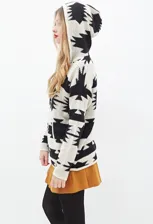

In [13]:
train_dataset[1][1]["content"][0]["image"]

In [16]:
train_dataset[1]

[{'role': 'system',
  'content': [{'type': 'text',
    'text': 'You are a fashion product expert assistant who excels at identifying product types from images and generating concise descriptions.'}]},
 {'role': 'user',
  'content': [{'type': 'image',
    'image': <PIL.WebPImagePlugin.WebPImageFile image mode=RGB size=153x224>},
   {'type': 'text', 'text': 'What is this product?'}]},
 {'role': 'assistant',
  'content': [{'type': 'text',
    'text': 'women/sweatshirts: The shirt this woman wears has long sleeves and it is with knitting fabric and graphic patterns. This woman wears a three-point shorts, with cotton fabric and solid color patterns. There is a hat in her head. This lady wears leggings.'}]}]

### Check the fine tuned mode output

In [40]:
clear_memory()

GPU allocated memory: 7.01 GB
GPU reserved memory: 15.22 GB


In [41]:
from transformers import BitsAndBytesConfig

# BitsAndBytesConfig int-4 config
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True, bnb_4bit_use_double_quant=True, bnb_4bit_quant_type="nf4", bnb_4bit_compute_dtype=torch.bfloat16
)

# Load model and tokenizer
model = Qwen2_5_VLForConditionalGeneration.from_pretrained(
    model_id, 
    torch_dtype="auto", # torch.bfloat16,
    #attn_implementation="flash_attention_2",
    device_map="auto",
    quantization_config=bnb_config
)

processor = AutoProcessor.from_pretrained(model_id)

adapter_path = os.path.join(model_dataset_path, "qwen2.5-3b-instruct-trl-sft-deepfashion")
model.load_adapter(adapter_path)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [42]:
train_dataset[1][:-1]

[{'role': 'system',
  'content': [{'type': 'text',
    'text': 'You are a fashion product expert assistant who excels at identifying product types from images and generating concise descriptions.'}]},
 {'role': 'user',
  'content': [{'type': 'image',
    'image': <PIL.WebPImagePlugin.WebPImageFile image mode=RGB size=153x224>},
   {'type': 'text', 'text': 'What is this product?'}]}]

In [43]:
# Example of how to call the method with sample:
sample = train_dataset[1][:-1] # remove assistant message
output = generate_text_from_sample(model, processor, sample)
output

'women/sweatshirts: The person wears a long-sleeve sweater with graphic patterns. The sweater is with cotton fabric. It has a round neckline. The person wears a three-point pants. The pants are with cotton fabric and solid color patterns. There is an accessory on her wrist. This lady wears a ring.'

In [ ]:
dataset: The shirt this woman wears has long sleeves and it is with knitting fabric and graphic patterns. This woman wears a three-point shorts, with cotton fabric and solid color patterns. There is a hat in her head. This lady wears leggings.

In [44]:
train_dataset[1][1:-1]

[{'role': 'user',
  'content': [{'type': 'image',
    'image': <PIL.WebPImagePlugin.WebPImageFile image mode=RGB size=153x224>},
   {'type': 'text', 'text': 'What is this product?'}]}]

In [45]:
sample = train_dataset[1][1:-1] # remove assistant message and system message
output = generate_text_from_sample(model, processor, sample) # with the system message
output

'This is a female long-sleeve sweater with a hood. The pattern of the fabric is mixed. The neckline of the clothing is round.'

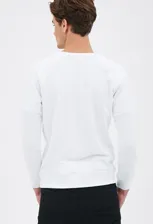

In [54]:
 test_dataset[2][1]["content"][0]["image"]

In [55]:
sample = test_dataset[2][:-1] # remove assistant message
output = generate_text_from_sample(model, processor, sample)
output

'men/sweatshirts: The person wears a long-sleeve sweater with solid color patterns. The sweater is with cotton fabric.'

### Check the original model output

In [35]:
clear_memory()

GPU allocated memory: 7.01 GB
GPU reserved memory: 7.65 GB


In [36]:
# BitsAndBytesConfig int-4 config
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True, bnb_4bit_use_double_quant=True, bnb_4bit_quant_type="nf4", bnb_4bit_compute_dtype=torch.bfloat16
)

# Load model and tokenizer
original_model = Qwen2_5_VLForConditionalGeneration.from_pretrained(
    model_id, 
    torch_dtype=torch.float16,
    attn_implementation="flash_attention_2",
    device_map="auto",
    quantization_config=bnb_config
)

processor = AutoProcessor.from_pretrained(model_id, padding_side='left')

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [39]:
sample = train_dataset[1][:-1] # remove assistant message
output = generate_text_from_sample(original_model, processor, sample)
output

'This is a hoodie with a unique design featuring a black and white tie-dye pattern on the upper half of the garment, transitioning into a solid color on the lower half. The hoodie has a hood and appears to be made of a soft, comfortable fabric suitable for casual wear or layering.'

In [48]:
sample = train_dataset[1][1:-1] # remove assistant message and system message 
output = generate_text_from_sample(original_model, processor, sample)
output

'This appears to be a hoodie with a unique design featuring a black and white pattern that resembles a tie-dye effect. The hoodie has a hood, long sleeves, and seems to be made of a soft, comfortable fabric suitable for casual wear or cooler weather. The design includes a mix of solid colors and patterns, giving it a modern and stylish look.'

In [50]:
new_system_message = "You are a fashion product expert assistant who excels at identifying product types from images and generating concise descriptions. Please also respond with categories in such format: men/shirts or women/dresses: this is the product description."
sample = train_dataset[1][:-1] # remove assistant message
sample[0]['content'][0]['text'] = new_system_message
sample

[{'role': 'system',
  'content': [{'type': 'text',
    'text': 'You are a fashion product expert assistant who excels at identifying product types from images and generating concise descriptions. Please also respond with categories in such format: men/shirts or women/dresses: this is the product description.'}]},
 {'role': 'user',
  'content': [{'type': 'image',
    'image': <PIL.WebPImagePlugin.WebPImageFile image mode=RGB size=153x224>},
   {'type': 'text', 'text': 'What is this product?'}]}]

In [51]:
output = generate_text_from_sample(original_model, processor, sample)
output

"This product is a women's hoodie. The description suggests it has a unique design, possibly featuring a tie-dye pattern, and includes a hood for added warmth. It appears to be a casual, comfortable piece of clothing suitable for everyday wear."

In [46]:
## Print the training result

In [ ]:
!pip install matplotlib # for the following result rendering

,Step,Training Loss,Validation Loss
0,10,5.0621,4.290996
1,20,3.8803,3.432539
2,30,3.1211,2.709153
3,40,2.3759,1.991729
4,50,1.7846,1.558664
...,...,...,...
313,3140,0.4522,0.451716
314,3150,0.4518,0.451184
315,3160,0.4483,0.450499
316,3170,0.4538,0.451066


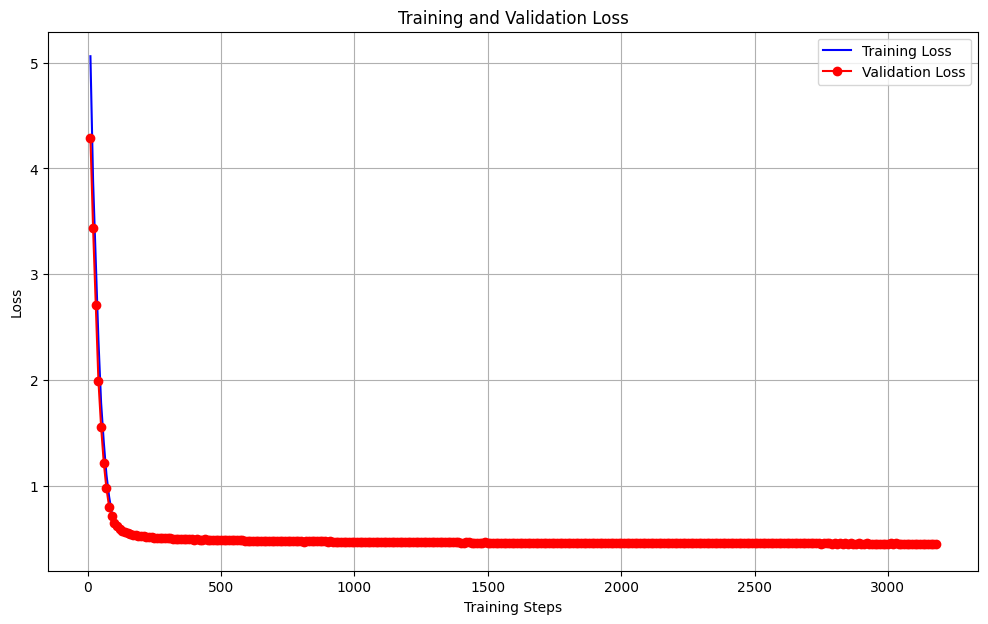

In [28]:
import json
import matplotlib.pyplot as plt
import pandas as pd
import glob
import os
from IPython.display import display

# === 设置路径 ===
checkpoints_path = training_args.output_dir
checkpoint_dirs = sorted(
    glob.glob(os.path.join(checkpoints_path, "checkpoint-*")),
    key=lambda x: int(x.split("-")[-1])
)

# === 日志容器 ===
loss_logs = []
eval_logs = []

# === 读取所有 trainer_state.json ===
for ckpt in checkpoint_dirs:
    trainer_state_path = os.path.join(ckpt, "trainer_state.json")
    if not os.path.exists(trainer_state_path):
        continue
    with open(trainer_state_path, "r") as f:
        trainer_state = json.load(f)
    log_history = trainer_state.get("log_history", [])

    for entry in log_history:
        step = entry.get("step")
        if step is None:
            continue
        if "loss" in entry:
            loss_logs.append({"Step": int(step), "Training Loss": round(entry["loss"], 6)})
        if "eval_loss" in entry:
            eval_logs.append({"Step": int(step), "Validation Loss": round(entry["eval_loss"], 6)})

# === 构建 DataFrames 并按 Step 合并 ===
df_loss = pd.DataFrame(loss_logs).drop_duplicates("Step").set_index("Step")
df_eval = pd.DataFrame(eval_logs).drop_duplicates("Step").set_index("Step")

# 合并成一张表（按 step 对齐）
df = pd.concat([df_loss, df_eval], axis=1).sort_index().reset_index()

# === 显示表格 ===
display(df)

# === 绘图 ===
plt.figure(figsize=(12, 7))

if "Training Loss" in df.columns:
    plt.plot(df["Step"], df["Training Loss"], label="Training Loss", color="blue")

if "Validation Loss" in df.columns:
    plt.plot(df["Step"], df["Validation Loss"], label="Validation Loss", color="red", marker='o')

plt.xlabel("Training Steps")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
clear_memory()

In [35]:
from transformers import BitsAndBytesConfig

# BitsAndBytesConfig int-4 config
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True, bnb_4bit_use_double_quant=True, bnb_4bit_quant_type="nf4", bnb_4bit_compute_dtype=torch.bfloat16
)

# Load model and tokenizer
model = Qwen2_5_VLForConditionalGeneration.from_pretrained(
    model_id, 
    torch_dtype="auto", # torch.bfloat16,
    #attn_implementation="flash_attention_2",
    device_map="auto",
    quantization_config=bnb_config
)

processor = AutoProcessor.from_pretrained(model_id)

adapter_path = "/data/sdb/qwen2.5-3b-instruct-trl-sft-deepfashion"
model.load_adapter(adapter_path)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
train_dataset[1][:2]

In [38]:
def generate_text_from_sample1(model, processor, sample, max_new_tokens=1024, device="cuda"):
    # Prepare the text input by applying the chat template
    text_input = processor.apply_chat_template(
        sample[0:2], tokenize=False, add_generation_prompt=True  # Use the sample without the system message
    )

    # Process the visual input from the sample
    image_inputs, _ = process_vision_info(sample)

    # Prepare the inputs for the model
    model_inputs = processor(
        text=[text_input],
        images=image_inputs,
        return_tensors="pt",
    ).to(
        device
    )  # Move inputs to the specified device

    # Generate text with the model
    generated_ids = model.generate(**model_inputs, max_new_tokens=max_new_tokens)

    # Trim the generated ids to remove the input ids
    trimmed_generated_ids = [out_ids[len(in_ids) :] for in_ids, out_ids in zip(model_inputs.input_ids, generated_ids)]

    # Decode the output text
    output_text = processor.batch_decode(
        trimmed_generated_ids, skip_special_tokens=True, clean_up_tokenization_spaces=False
    )

    return output_text[0]  # Return the first decoded output text

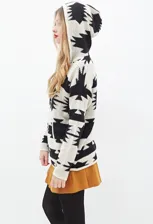

In [32]:
train_dataset[1][1]["content"][0]["image"]

In [ ]:
output = generate_text_from_sample1(model, processor, test_dataset[1])
output